In [45]:
# import libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import imageio
import cv2
import getpass
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
import tensorflow.keras as keras
import tensorflow as tf
from keras.callbacks import Callback
import datetime
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import sys
sys.path.append('../')
import imp

import data_utils as du
import ml_models

In [35]:
def get_top_5(row):
    preds = [row[i] for i in range(10)]
    top_5 = sorted(zip(preds, range(10)), reverse=True)[:5]
    indices = [n[1] for n in top_5]
    if row['true_label'] in indices: 
        out = 1
    else: 
        out = 0
    return out

def get_percent(row, c): 
    val = row[c]
    return float(val) / float(row['n_obs'])

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function plots a confusion matrix.

    Args:
        cm (array): Confusion matrix.
        classes (list): List of class labels.
        normalize (bool): Whether to normalize the matrix or not.
        title (str): Plot title.
        cmap (matplotlib colormap): Colormap to be used for the plot.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  #  print("Confusion Matrix:")
  #  print(cm)

    thresh = cm.max() / 2.
    # for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #     plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
# load testing dataset & look at prediction accuracy to compare against saved model predictions '

df = pd.read_csv('/home/azureuser/notebooks/alichase/ml-workflow/model_ckpt/model-summary-cnn-v1-b3.csv')

In [22]:
df

,full_path,high_group,pred_label,true_label,is_correct,0,1,2,3,4,5,6,7,8,9,top_5
0,/home/azureuser/data/NAAMES_ml/D20160513T22082...,Other,7,7,1,1.788756e-05,1.146114e-18,2.892286e-07,9.871857e-06,4.914940e-13,3.955169e-03,1.792351e-06,0.995379,6.035990e-04,3.274584e-05,1
1,/home/azureuser/data/NAAMES_ml/D20180402T13445...,Other,0,7,0,5.395499e-01,1.456711e-04,4.600495e-09,2.238769e-04,1.425122e-01,6.822130e-03,3.214117e-11,0.083037,2.268619e-01,8.470257e-04,1
2,/home/azureuser/data/NAAMES_ml/D20160528T22330...,Other,7,7,1,1.197600e-04,5.510693e-15,2.841731e-05,7.511244e-05,6.837943e-09,4.465281e-04,6.920837e-07,0.994058,8.560426e-05,5.186173e-03,1
3,/home/azureuser/data/NAAMES_ml/D20160531T08382...,Other,7,7,1,2.408427e-04,2.925888e-11,4.873408e-06,3.933519e-03,2.065363e-09,2.730137e-01,1.542221e-04,0.718308,5.967846e-04,3.748273e-03,1
4,/home/azureuser/data/NAAMES_ml/D20160526T21432...,Diatom,3,3,1,3.128773e-04,4.062051e-14,6.139785e-05,7.101523e-01,2.181512e-10,2.108471e-04,4.933558e-06,0.287664,2.219727e-04,1.371984e-03,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399775,/home/azureuser/data/NAAMES_ml/D20160530T23394...,Eugleno,6,6,1,6.013484e-13,3.751894e-26,3.330312e-09,7.386912e-06,3.777496e-13,6.410740e-06,9.999207e-01,0.000065,1.452780e-07,5.057208e-07,1
399776,/home/azureuser/data/NAAMES_ml/D20160529T01183...,Dinoflagellate,5,5,1,7.562776e-08,1.580177e-10,2.543378e-09,1.973915e-06,4.075483e-10,9.998869e-01,1.908313e-09,0.000110,5.005263e-08,3.868345e-07,1
399777,/home/azureuser/data/NAAMES_ml/D20160528T18364...,NaN,9,9,1,5.158942e-07,7.589195e-09,5.717600e-09,2.155094e-05,9.907630e-07,1.271514e-05,1.036836e-10,0.015101,7.108635e-05,9.847918e-01,1
399778,/home/azureuser/data/NAAMES_ml/D20180410T12230...,Other,7,7,1,4.261079e-08,9.153697e-30,4.726195e-11,1.692143e-08,7.329000e-19,2.060179e-07,3.326508e-17,0.999673,1.107582e-07,3.268361e-04,1


In [23]:
# obtain overall accruacy for final model prediction 

float(sum(df.is_correct))/float(len(df))

0.831672419830907

In [24]:
df_agg = df.groupby('high_group').agg({'full_path' : 'count', 'is_correct' : 'sum', 'top_5' : 'sum'})

In [25]:
df_agg

,full_path,is_correct,top_5
high_group,,,
Chloro,2411,1846,2351
Cilliate,722,615,691
Crypto,9053,8329,8933
Diatom,44585,42684,44517
Dictyo,2637,2503,2602
Dinoflagellate,27989,23755,27937
Eugleno,13096,11820,12947
Other,254146,201368,254142
Prymnesio,4443,3294,4352


In [26]:
df_agg.reset_index(inplace=True)
df_agg

,high_group,full_path,is_correct,top_5
0,Chloro,2411,1846,2351
1,Cilliate,722,615,691
2,Crypto,9053,8329,8933
3,Diatom,44585,42684,44517
4,Dictyo,2637,2503,2602
5,Dinoflagellate,27989,23755,27937
6,Eugleno,13096,11820,12947
7,Other,254146,201368,254142
8,Prymnesio,4443,3294,4352


In [27]:
df_agg.columns = ['high_group', 'n_obs', 'top_1', 'top_5']
df_agg['top_1_acc'] = df_agg.apply(lambda row: get_percent(row, 'top_1'), axis=1)
df_agg['top_5_acc'] = df_agg.apply(lambda row: get_percent(row, 'top_5'), axis=1)

df_agg.sort_values('top_1_acc', ascending=False)

,high_group,n_obs,top_1,top_5,top_1_acc,top_5_acc
3,Diatom,44585,42684,44517,0.957362,0.998475
4,Dictyo,2637,2503,2602,0.949185,0.986727
2,Crypto,9053,8329,8933,0.920027,0.986745
6,Eugleno,13096,11820,12947,0.902566,0.988622
1,Cilliate,722,615,691,0.851801,0.957064
5,Dinoflagellate,27989,23755,27937,0.848726,0.998142
7,Other,254146,201368,254142,0.792332,0.999984
0,Chloro,2411,1846,2351,0.765657,0.975114
8,Prymnesio,4443,3294,4352,0.741391,0.979518


In [39]:
# calculate a confusion matrix
cm = confusion_matrix(df.true_label,df.pred_label)

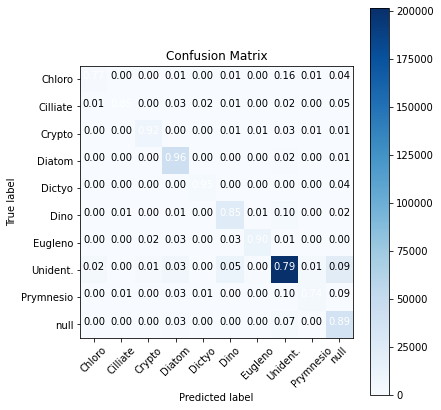

In [37]:
import itertools

# Define your class labels
class_labels = ["Chloro", "Cilliate", "Crypto", "Diatom", "Dictyo", "Dino", "Eugleno", "Unident.", "Prymnesio", "null"]

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Confusion Matrix')
plt.show()


In [40]:
class_labels = ["Chloro", "Cilliate", "Crypto", "Diatom", "Dictyo", "Dino", "Eugleno", "Unident.", "Prymnesio", "null"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_labels)

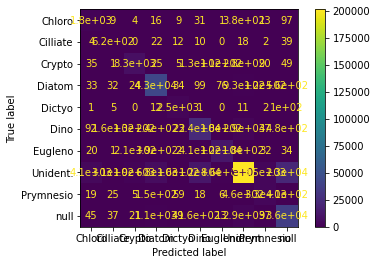

In [43]:
disp.plot()
plt.show()

In [47]:
test = accuracy_score(df.true_label,df.pred_label,normalize=True)

In [48]:
test

0.831672419830907

In [52]:
cr = classification_report(df.true_label,df.pred_label, target_names=class_labels, digits=4)
print(cr)

              precision    recall  f1-score   support

      Chloro     0.2975    0.7657    0.4286      2411
    Cilliate     0.5138    0.8518    0.6410       722
      Crypto     0.7845    0.9200    0.8469      9053
      Diatom     0.8304    0.9574    0.8894     44585
      Dictyo     0.8770    0.9492    0.9117      2637
        Dino     0.6406    0.8487    0.7301     27989
     Eugleno     0.9053    0.9026    0.9039     13096
    Unident.     0.9614    0.7923    0.8687    254146
   Prymnesio     0.4592    0.7414    0.5671      4443
        null     0.5971    0.8912    0.7151     40698

    accuracy                         0.8317    399780
   macro avg     0.6867    0.8620    0.7502    399780
weighted avg     0.8705    0.8317    0.8402    399780



In [67]:
def get_classification_report(y_test, y_pred):
    '''Source: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format'''
    from sklearn import metrics
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
    return df_classification_report

In [68]:
df_cr = get_classification_report(df.true_label,df.pred_label)
df_cr

,precision,recall,f1-score,support
4,0.877015,0.949185,0.911674,2637.000000
6,0.905262,0.902566,0.903912,13096.000000
3,0.830444,0.957362,0.889398,44585.000000
7,0.961413,0.792332,0.868722,254146.000000
2,0.784497,0.920027,0.846873,9053.000000
weighted avg,0.870464,0.831672,0.840210,399780.000000
accuracy,0.831672,0.831672,0.831672,0.831672
macro avg,0.686688,0.862029,0.750247,399780.000000
5,0.640573,0.848726,0.730103,27989.000000
9,0.597119,0.891248,0.715121,40698.000000


In [81]:
df_cr = df_cr.drop(['weighted avg','accuracy','macro avg'])

In [50]:
matrix = confusion_matrix(df.true_label,df.pred_label)
matrix.diagonal()/matrix.sum(axis=1)

array([0.7656574 , 0.85180055, 0.92002651, 0.95736234, 0.94918468,
       0.84872629, 0.90256567, 0.79233197, 0.74139095, 0.89124773])

In [71]:
class_labels

['Chloro',
 'Cilliate',
 'Crypto',
 'Diatom',
 'Dictyo',
 'Dino',
 'Eugleno',
 'Unident.',
 'Prymnesio',
 'null']

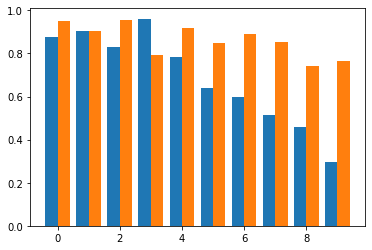

In [85]:
x = np.arange(10)
plt.bar(x-0.2,df_cr.precision,0.4)
plt.bar(x+0.2,df_cr.recall,0.4)
plt.show()

In [89]:
df_cr.columns=['precision','recall','f1','num']
df_cr

,precision,recall,f1,num
4,0.877015,0.949185,0.911674,2637.0
6,0.905262,0.902566,0.903912,13096.0
3,0.830444,0.957362,0.889398,44585.0
7,0.961413,0.792332,0.868722,254146.0
2,0.784497,0.920027,0.846873,9053.0
5,0.640573,0.848726,0.730103,27989.0
9,0.597119,0.891248,0.715121,40698.0
1,0.513784,0.851801,0.640959,722.0
8,0.459222,0.741391,0.567149,4443.0
0,0.297550,0.765657,0.428555,2411.0


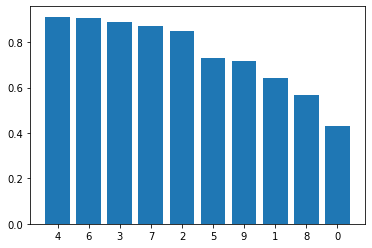

In [90]:
plt.bar(df_cr.index,df_cr.f1)
plt.show()